## Does `EnergyModel` actually work for estimation?

The notebook runs a load of automated tests and gets the `EnergyModel` estimation of energy usage, then compares it with the values from energy.json.

In [1]:
from env import TestEnv
import pandas as pd
import json
import os
from conf import LisaLogging
from bart.common.Utils import area_under_curve
from trappy.plotter import plot_trace
from IPython.display import display
from trappy import ILinePlot
from trappy.stats.grammar import Parser
import pandas as pd

LisaLogging.setup()
import logging
logging.getLogger('Trace').setLevel(logging.ERROR)
logging.getLogger('Analysis').setLevel(logging.WARNING)
%matplotlib inline

2017-01-09 17:06:56,644 INFO    : root         : Using LISA logging configuration:
2017-01-09 17:06:56,646 INFO    : root         :   /home/brejac01/sources/lisa/logging.conf


In [2]:
import tests.eas.generic
from tests.eas.generic import EnergyModelTest

## Run all the tests
This will probalby take ages

In [3]:
# Disable drawing power from USB
!adb -s GA0113TP0180 shell "echo 'echo 0 > /sys/class/power_supply/battery/charging_enabled' | su"

error: device 'GA0113TP0180' not found


In [4]:
scs = EnergyModelTest.__subclasses__()

In [5]:
tests = []
all_experiments = []
measured_energy = []
est_energy = []

for cls in scs[0:1]:
    cls.setUpClass()
    if not cls.te.emeter:
        raise Exception("This notebook won't work without an energy meter configured")
    t = cls()
    tests.append(t)
    for exp in t.executor.experiments:
        all_experiments.append(exp)
        json_path = os.path.join(exp.out_dir, "energy.json")
        with open(json_path) as f:
            energy = json.load(f)
        energy = sum(energy.values())
        measured_energy.append(energy)
                
        est_power = t.get_power_df(t.executor.experiments[0])['power']
        est_energy.append(area_under_curve(est_power))

2017-01-09 17:06:56,826 INFO    : LisaTest     : Setup tests execution engine...
2017-01-09 17:06:56,827 INFO    : TestEnv      : Using base path: /home/brejac01/sources/lisa
2017-01-09 17:06:56,828 INFO    : TestEnv      : Loading default (file) target configuration
2017-01-09 17:06:56,829 INFO    : TestEnv      : Loading target configuration [/home/brejac01/sources/lisa/target.config]...
2017-01-09 17:06:56,831 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-01-09 17:06:56,832 INFO    : TestEnv      : Devlib modules to load: ['bl', u'cpuidle', 'cgroups', 'hwmon', 'cpufreq']
2017-01-09 17:06:56,833 INFO    : TestEnv      : Connecting linux target:
2017-01-09 17:06:56,834 INFO    : TestEnv      :   username : brendan
2017-01-09 17:06:56,835 INFO    : TestEnv      :       host : 192.168.2.2
2017-01-09 17:06:56,836 INFO    : TestEnv      :   password : password
2017-01-09 17:06:56,837 INFO    : TestEnv      : Connection settings:
2017-01-09 17:06:56,838 INFO    :

2017-01-09 17:08:00,121 INFO    : Workload     : Workload execution START:
2017-01-09 17:08:00,123 INFO    : Workload     :    /home/brendan/devlib-target/bin/rt-app /home/brendan/devlib-target/run_dir/one_small_00.json 2>&1
2017-01-09 17:08:09,511 INFO    : Executor     : Collected FTrace binary trace:
2017-01-09 17:08:09,513 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/1/trace.dat
2017-01-09 17:08:09,514 INFO    : Executor     : Collected FTrace function profiling:
2017-01-09 17:08:09,515 INFO    : Executor     :    <res_dir>/rtapp:energy_aware:one_small/1/trace_stat.json
2017-01-09 17:08:09,516 INFO    : Executor     : --------------------------------------------------------------------------------
2017-01-09 17:08:09,517 INFO    : Executor     : 
2017-01-09 17:08:09,518 INFO    : Executor     : ################################################################################
2017-01-09 17:08:09,520 INFO    : Executor     : Experiments execution completed
2017-0

Maximum estimated system energy: 1725
Maximum estimated system energy: 1725


# Compare `EnergyModel` estimation with measured value

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


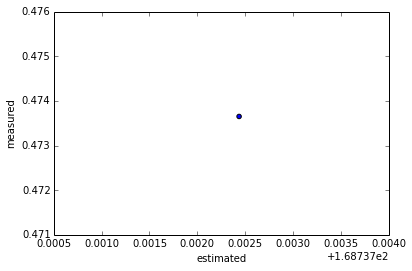

In [6]:
df = pd.DataFrame({'measured': measured_energy, 'estimated': est_energy}, columns=['measured', 'estimated'])
df.plot.scatter(x='estimated', y='measured')

In [7]:
tests

[<tests.eas.generic.OneSmallTask testMethod=runTest>]

## Show results

Now we'll plot:

- Task residency
- CPU frequency (if available)
- Energy recorded by energy meter (if available)
- Energy estimated:
  - By `sched_group_energy` in the kernel (using the `sched_energy_diff` trace event)
  - By `EnergyModel`, according to the ideal utilization values that would be expected for the observed task placement
  - By `EnergyMOdel`, according to the utilization values extracted via the `sched_load_avg_cpu` event

In [8]:
t = tests[0]
ex = t.executor.experiments[0]
trace = t.get_trace(ex)

Maximum estimated system energy: 1725


In [9]:
trace.ftrace.sched_group_energy.data_frame.sg_cpus.head()

Time
0.000000    NaN
0.000013    0x2
0.000017    NaN
0.000024    0x4
0.000028    NaN
Name: sg_cpus, dtype: object

In [10]:
sr = trace.ftrace.sched_group_energy.data_frame.sg_cpus
def f(item):
    if type(item) == str:
        return int(item, 0)
    else:
        return item
trace.ftrace.sched_group_energy.data_frame.sg_cpus = sr.apply(f)
trace.ftrace.sched_group_energy.data_frame.head()

,__comm,__cpu,__pid,active,cap_idx,group_util,idle,idle_idx,max_util,sg_cap_cpus,sg_cpus
Time,,,,,,,,,,,
0.000000,trace-cmd,5,497,NaN,NaN,NaN,NaN,NaN,0.0,0x6,NaN
0.000013,trace-cmd,5,497,0.0,0.0,0.0,0.0,3.0,NaN,0x6,2.0
0.000017,trace-cmd,5,497,NaN,NaN,NaN,NaN,NaN,0.0,0x6,NaN
0.000024,trace-cmd,5,497,0.0,0.0,0.0,0.0,3.0,NaN,0x6,4.0
0.000028,trace-cmd,5,497,NaN,NaN,NaN,NaN,NaN,0.0,0x6,NaN


In [11]:
df = trace.ftrace.sched_group_energy.data_frame
df = df.groupby(level=0).last() # drop rows with duplicate index
df = df.pivot(columns='sg_cpus')[['idle', 'active']]

def to_bits(n):
    ret = []
    for i in range(6):
        if n % 2:
            ret += [i]
        n /= 2
    return tuple(ret)

def fix_cols(df):
    df = pd.DataFrame(df)
    df.columns = [to_bits(col) for col in df.columns]
    return df

sched_idle_df = df['idle']
sched_active_df = df['active']

AssertionError: Gaps in blk ref_locs

In [ ]:
p = Parser(trace.ftrace)
util_df = p.solve('sched_load_avg_cpu:util_avg').fillna(0)

keys = None
def f(row, component='active'):
    nrg = t.te.nrg_model.estimate_from_cpu_util(row.tolist(), combine=False)
    
    del nrg['power']
    global keys
    if not keys:
        keys = sorted(nrg.keys(), key=len)
        
    return pd.Series([v[component] for v in nrg.values()])

def get_component_df(component):
    df = util_df.apply(lambda row: f(row, component), axis=1)
    df.columns = keys
    return df

est_idle_df = get_component_df('idle')
est_active_df = get_component_df('active')

In [ ]:
est_active_df.head()

In [ ]:
ILinePlot([sched_idle_df, est_idle_df], column=(2,)).view()

In [ ]:
def examine(test, experiment_idx=0):
    ex = test.executor.experiments[experiment_idx]
    
    # Show task residency
    trace = test.get_trace(ex)
    plot_trace(trace.ftrace)
    
    if 'cpu_frequency' in trace.available_events:
        print "CPU FREQ:"
        p = Parser(trace.ftrace)
        freq_df = p.solve('cpu_frequency:frequency')
        # ILinePlot(freq_df, drawstyle='steps-post').view()
    
    csv_path = os.path.join(ex.out_dir, "samples_Device0.csv")
    if os.path.exists(csv_path):
        print "RECORDED ENERGY:"
        # Show recorded energy
        samples_df = pd.read_csv(csv_path, sep=", ", engine='python', index_col='"timestamp ms"')
        samples_df.index.name='time'
        samples_df.index /= 1000
        samples_df = samples_df[['"power mW"']]
        samples_df.columns = ['power']
        ILinePlot(samples_df, column='power').view()

    print "ESTIMATED ENERGY:"
    # Show estimated energy
    est_placement_df = test.get_power_df(ex)

    sched_df = trace.ftrace.sched_energy_diff.data_frame
    # TODO: This is a hack to get only sched_energy_diff estimations where the 
    # potential migration was between clusters, i.e. both top-level sched_groups were considered.
    # Instead of hard-coding this we should detect that case using data in the EnergyModel.
    # Or hack the kernel to always consider all sched_groups
    # sched_df = df[df['src_cpu'].isin((1, 2)) != df['dst_cpu'].isin((1, 2))]

    p = Parser(trace.ftrace)
    util_df = p.solve('sched_load_avg_cpu:util_avg').fillna(0)
    def f(row):
        return t.te.nrg_model.estimate_from_cpu_util(row.tolist())['power']
    est_util = util_df.apply(f, axis=1)

    c = sched_df.columns.tolist()

    df = pd.concat([sched_df['nrg_before'].to_frame(), 
                    est_util.to_frame(), 
                    est_placement_df['power'].to_frame()])

    df = df.sort_index().fillna(method='ffill')
    df.columns = ['sched_group_energy', 'EnergyModel (sched_load_avg_task)', 'EnergyModel (placement)']

    display(df.corr())
    ILinePlot(df, column=['sched_group_energy', 'EnergyModel (sched_load_avg_task)', 'EnergyModel (placement)'], drawstyle='steps-before').view()
    
examine(tests[0])

In [ ]:
df.corr()